In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model, model_selection
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [293]:
#read dataset into pandas 
kc_house_data = pd.read_csv("kc_house_data.csv", parse_dates = ['date'])
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [294]:
kc_house_data = kc_house_data.sort_values(by=['date'])

### Finding outliers

In [295]:
#finding outliers for housing price

model = IsolationForest(random_state = 0, contamination = float(0.01))
model.fit(kc_house_data[['price']])

kc_house_data['score'] = model.decision_function(kc_house_data[['price']])
kc_house_data['anomaly_value'] = model.predict(kc_house_data[['price']])

outliers = kc_house_data.loc[kc_house_data['anomaly_value'] == -1]
outlier_index = list(outliers.index)

#datapoints classified -1 are anomalous
kc_house_data['anomaly_value'].value_counts()

 1    21397
-1      216
Name: anomaly_value, dtype: int64

<AxesSubplot:>

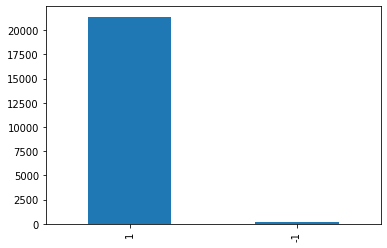

In [296]:
kc_house_data['anomaly_value'].value_counts().plot(kind = 'bar')

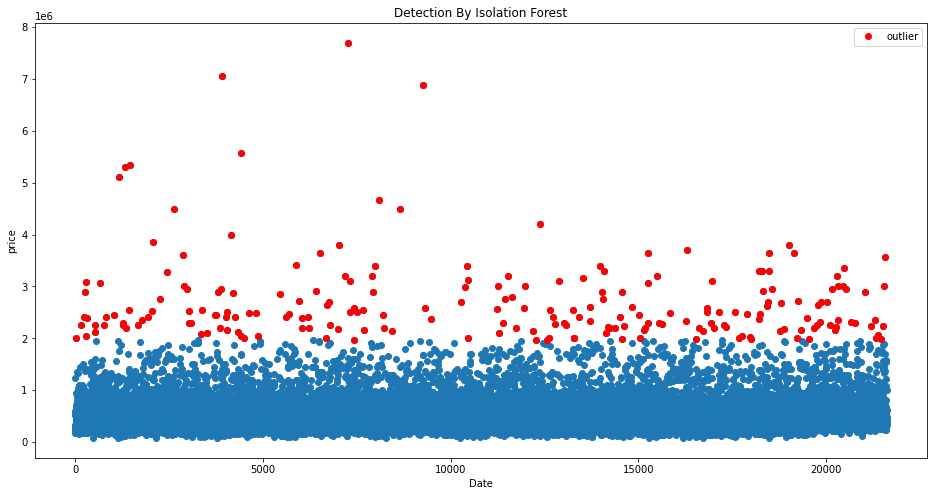

In [297]:
plt.figure(figsize = (16, 8))

plt.plot(kc_house_data['price'], 'o')
plt.plot(outliers['price'], 'o', color = 'red', label = 'outlier')
plt.title('Detection By Isolation Forest')

plt.xlabel('Date')
plt.ylabel('price')
plt.legend()

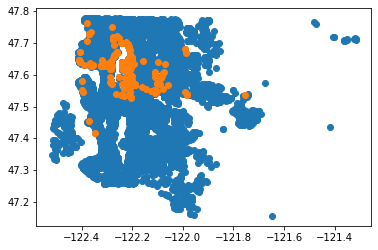

In [298]:
plt.scatter(x=kc_house_data['long'], y=kc_house_data['lat'])
plt.scatter(x=outliers['long'],y=outliers['lat'])
plt.show()

In [299]:
#Compute the correlation coefficient with the response (Price)
features = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot','floors','waterfront','view','condition','grade',
            'sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15']
correlationlist = []
for x in features:
    r = np.corrcoef(kc_house_data['price'], kc_house_data[x])
    correlationlist.append((x,r[0,1]))
    
correlationdf = pd.DataFrame(correlationlist, columns =['Feature','Correlation'])

print(correlationdf) 

          Feature  Correlation
0        bedrooms     0.308350
1       bathrooms     0.525138
2     sqft_living     0.702035
3        sqft_lot     0.089661
4          floors     0.256794
5      waterfront     0.266369
6            view     0.397293
7       condition     0.036362
8           grade     0.667434
9      sqft_above     0.605567
10  sqft_basement     0.323816
11       yr_built     0.054012
12   yr_renovated     0.126434
13            lat     0.307003
14           long     0.021626
15  sqft_living15     0.585379
16     sqft_lot15     0.082447


All of the features have a positive correlation coefficient. The best correlation features to price were square footage of the apartments interior living space, number of bathrooms, grade of construction and design, and square footage of the nearest apartments interior living space. This make sense to have the highest correlation, as more square feet would indicate a more expensive house.

None of the features have a negative correlation, which is interesting. Some are close to zero, such as yr_build, long, and condition. One that could have a negative correlation is a pollution metric. If there is higher pollution in an area, the housing prices are likely lower

### Model Training and Testing

In [300]:
features = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot','floors','waterfront','view','condition','grade',
            'sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15']

feat = kc_house_data[features]
target = kc_house_data['price']

In [301]:
x_train,X_test,y_train,y_test = train_test_split(feat,target,test_size=0.2,random_state=0) 

In [302]:
train = linear_model.LinearRegression()
train.fit(x_train, y_train)
train_r_squared = train.score(x_train, y_train)
train_y_prediction = train.predict(X_test)
mse = mean_squared_error(y_test, train_y_prediction)
print("Train R Squared: ",train_r_squared)

Train R Squared:  0.6993487112112486


In [303]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

<AxesSubplot:xlabel='feature_importance', ylabel='feature_names'>

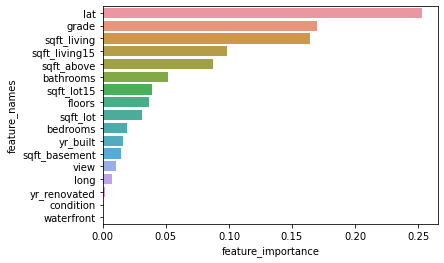

In [304]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(updatedfeat.columns)

data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

#### Drop outliers from the dataset

In [305]:
kc_house_data.drop(kc_house_data[kc_house_data['anomaly_value'] == -1].index, inplace = True)

In [306]:
updatedfeat = kc_house_data[features]
updatedtarget = kc_house_data['price']

In [307]:
x_train,X_test,y_train,y_test = train_test_split(updatedfeat,updatedtarget,test_size=0.2,random_state=0) 

In [308]:
train = linear_model.LinearRegression()
train.fit(x_train, y_train)
train_r_squared = train.score(x_train, y_train)
train_y_prediction = train.predict(X_test)
mse = mean_squared_error(y_test, train_y_prediction)
print("Train R Squared: ",train_r_squared)

Train R Squared:  0.7094272730094928


In [309]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

<AxesSubplot:xlabel='feature_importance', ylabel='feature_names'>

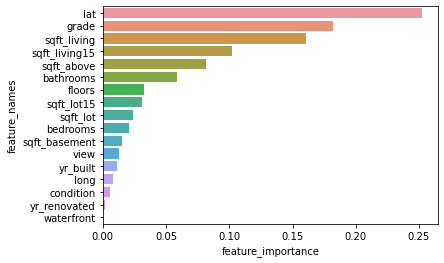

In [310]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(updatedfeat.columns)

data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

#### Just using the outliers dataset 

In [311]:
outlierfeat = outliers[features]
outliertarget = outliers['price']

In [312]:
x_train,X_test,y_train,y_test = train_test_split(outlierfeat,outliertarget,test_size=0.2,random_state=0) 

In [313]:
train = linear_model.LinearRegression()
train.fit(x_train, y_train)
train_r_squared = train.score(x_train, y_train)
train_y_prediction = train.predict(X_test)
mse = mean_squared_error(y_test, train_y_prediction)
print("Train R Squared: ",train_r_squared)

Train R Squared:  0.6083100294362129


In [315]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

<AxesSubplot:xlabel='feature_importance', ylabel='feature_names'>

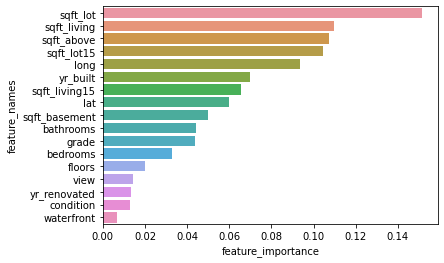

In [316]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(updatedfeat.columns)

data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])